In [6]:
import pandas as pd
import numpy as np
from datetime import timedelta, date, datetime
from fredapi import Fred
from matplotlib import pyplot as plt 
from matplotlib import style

# from datetime import datetime, timedelta, date

#Config is a user file stored in the parent directory
import sys
sys.path.insert(1, '../')
import config


In [7]:
"""_summary_

Defines fredget class:
Starts by calling the .get() method which pulls in data from FRED
Then allows the user to easily apply a series of transformations to that data 

Other methods of the class are geared towards data visualization
"""


class fredget:
    def __init__(self, api_key,plotstyle = 'seaborn', plotfont = 'Serif',figsize = (4,6)):
        
        #Store the API key 
        self.fred = Fred(api_key=api_key)
        
        #Store plot style parameters
        self.plotstyle = plotstyle
        self.font = plotfont
        self.figsize = figsize
        
        #Store this for frequency changes
        self.freq_map_w = {'a':52,'q':13,'m':4,'w':1}
        self.freq_map_m = {'a':12,'q':4,'m':1}
        self.freq_map_q = {'a':4,'q':1}
        self.freq_map_y = {'a':1}
        self.freq_map = {'w':self.freq_map_w,'m':self.freq_map_m,'q':self.freq_map_q,'a':self.freq_map_y}
        self.full_name_map = {'w':'Week','m':'Month','q':'Quarter','a':'Year'}
    
        
    #Setting a few internal Defaults for dates and plotting 
    today = date.today()
    start_default = date(1980, 1, 1)
    end_date_plot = today.strftime('%m-%d-%Y')
    start_date_plot = (today - timedelta(days = (365*10))).strftime('%m-%d-%Y')
    
    
#__________________Function to apply user presets when plotting_________________________   
#_______________________________________________________________________________________
    def plot_setup(self):
        plt.figure(figsize=self.figsize)
        plt.rcParams["font.family"] = self.font
        plt.rcParams['figure.figsize'] = self.figsize
        #plt.rcParams.update({'font.size': 22})
        plt.style.use(self.plotstyle)
        
        
#____________________Function to Retrieve the data from FRED____________________________
#_______________________________________________________________________________________
    def get(self,varlist, start_date=start_default, end_date=today,plots=True,freq="",name_map = dict()):
        df_collect = pd.DataFrame()

        #Loop over all input fred codes
        for count, var in enumerate(varlist):
            df_add = self.fred.get_series(var, observation_start = start_date, observation_end=end_date, frequency =freq).to_frame(name = var)
            info_add = self.fred.get_series_info(var).to_frame(name = var)
            print(f'Collected: {var} - {count+1}/{len(varlist)}')
            
            #If user changes the frequency, use this
            if freq != "":
                info_add.loc['cur_freq', var] = freq
            if var in name_map:
                info_add.loc['user_title', var] = name_map[var]
            else:
                info_add.loc['user_title', var] = info_add.loc['title', var]
                        
            if plots == True:
                df_add.plot(y=var, use_index=True, kind='line', title = info_add.loc['user_title', var], ylabel = info_add.loc['units', var] )
                
            if df_collect.empty == True:
                df_collect = df_add
                info_store = info_add
            else:
                df_collect = pd.merge(df_collect, df_add, left_index=True, right_index=True, how='outer')
                info_store = pd.merge(info_store, info_add, left_index=True, right_index=True, how='left')
                
        df_collect.sort_index()
        self.freq = freq
        self.data = df_collect
        self.metadata = info_store
        self.vars = varlist
   
        
#_______________________________________________________________________________________
    #A few methods for getting the data out
    def peekdf(self):
        return print(self.data.head())
    def getdf(self):
        return self.data
    def getinfo(self):
        return self.metadata
    
    
#Method for plotting a single series, will automatically use metadata
#_______________________________________________________________________________________

    def plot_single(self,var, date_start=start_date_plot, date_end=end_date_plot,save = True): 
        
        #Set style params
        fredget.plot_setup(self)
        
        startd = datetime.strptime(date_start,'%m-%d-%Y')
        endd = datetime.strptime(date_end,'%m-%d-%Y')
    
        title = self.metadata.loc['user_title', var]
        units = self.metadata.loc['units', var]
        
        plt.plot(self.data.index,self.data[var],label = title)   
        plt.ylabel(units)
        plt.xlim([startd, endd])
        plt.title(title)
        
#Method for plotting more than one series  
#_______________________________________________________________________________________
   
    def plot(self,title, units, date_start=start_date_plot, date_end=end_date_plot,save = True):  
        
        #Set style params
        fredget.plot_setup(self)
        
        startd = datetime.strptime(date_start,'%m-%d-%Y')
        endd = datetime.strptime(date_end,'%m-%d-%Y')
        
        #plot all of the series 
        for plotvar in self.vars:
            label_in = self.metadata.loc['user_title', plotvar]
            plt.plot(self.data.index,self.data[plotvar],label = label_in)

        plt.legend()
        plt.ylabel(units)
        plt.xlim([startd, endd])
        plt.title(title)
        
#Transformer function (used by other functions)
#_______________________________________________________________________________________
         
    def trans_single(self,var,selected_trans):  
        
        if selected_trans not in self.freq_map[self.freq]:
            raise Exception("Sorry, cannot upsample")
        else:
            shift = self.freq_map[self.freq][selected_trans]
            self.data[var] = 100*self.data[var].pct_change(shift)
            if selected_trans == 'a':
                self.metadata.loc['units_short', var] = 'yoy %'
                fname = 'Year'
            else:
                self.metadata.loc['units_short', var] = f'{selected_trans}o{selected_trans} %'
                fname = self.full_name_map[selected_trans]
            self.metadata.loc['units', var] = f'{fname} over {fname} Percent Change' 
               
#Transform all variables at once          
#_______________________________________________________________________________________

    def trans_all(self,freq):
        
        if self.freq not in self.freq_map:
            raise Exception("Sorry, cannot transform mixed frequency data, add freq = 'm', 'q','a' when collected with the get method")
        else:
            for var in self.vars:
                selected_trans = freq
                self.trans_single(var,selected_trans)

#Transform specified variables
#_______________________________________________________________________________________                   
    def trans_series(self,transform_dict):
        
        if self.freq not in self.freq_map:
            raise Exception("Sorry, cannot transform mixed frequency data, add freq = 'm', 'q','a' when collected with the get method")
        else:
            for var in transform_dict:
                selected_trans = transform_dict[var]
                self.trans_single(var,selected_trans)
         

#Plot data for X months following a set of dates
#Allows use to visualize how certain variables behave after crisis dates etc.      
#_______________________________________________________________________________________
    def plot_periods(self,var,dates,years_after,title=""):
        
        freq_var = self.metadata.loc['cur_freq', var]
        freq_periods = {'a':1,'q':4,'m':12,'w':52}
        step = freq_periods[freq_var]
        plot_ind = np.linspace(0,step,step)
        
        plt.figure()
        if self.freq not in self.freq_map:
            raise Exception("Sorry, cannot transform mixed frequency data, add freq = 'm', 'q','a' when collected with the get method")
        
        for datestart in dates:
            dateind = datetime.strptime(datestart,'%m-%d-%Y')
            end_date_plot = dateind + timedelta(days = (365*years_after))
            df_plot = self.data.loc[dateind:end_date_plot]
            steps = len(df_plot.index)
            plot_ind = np.linspace(0,steps,steps)
            plt.plot(plot_ind,df_plot[var],label = datestart)
            xlab = f'{self.full_name_map[freq_var]}s'
            plt.xlabel(xlab)
            plt.legend()
            plt.title(f"Developments after {years_after} years")

        


Collected: CPIUFDSL - 1/5
Collected: CPIETRANS - 2/5
Collected: CPIAUCSL - 3/5
Collected: CUSR0000SAH1 - 4/5
Collected: CUSR0000SAD - 5/5


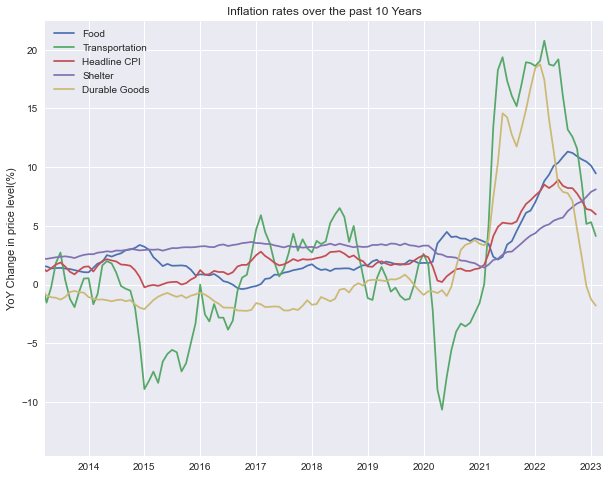

In [10]:
#Testing the function for collecting and plotting inflatiomn rates 
FRED_list = ['CPIUFDSL','CPIETRANS','CPIAUCSL','CUSR0000SAH1','CUSR0000SAD']
remap = {'CUSR0000SAH1': 'Shelter','CPIUFDSL':'Food', 'CPIAUCSL': 'Headline CPI','CPIETRANS': 'Transportation','CUSR0000SAD':'Durable Goods'}

fredobj = fredget(api_key=config.api_key,figsize=(10,8))
fredobj.get(FRED_list,plots=False,freq="m",name_map=remap)
fredobj.trans_all('a')
fredobj.plot(title = "Inflation rates over the past 10 Years",units = 'YoY Change in price level(%)')


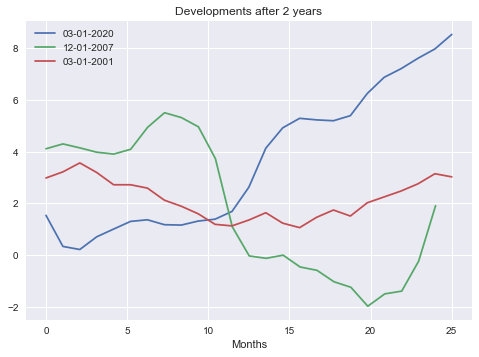

In [11]:
#Plot the historical decomp of headline cpi after recessions
date_set = ['03-01-2020','12-01-2007','03-01-2001']
fredobj.plot_periods('CPIAUCSL',date_set,2)

In [ ]:
#List of styles to incorporate
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [ ]:
#for now consider this code to be saved for reference 

#IGNORE OLD function calls
FRED_list = ['T10Y2Y','MORTGAGE30US','CPILFESL','CPIAUCSL']

remap = {'T10Y2Y': '10-Year Minus 2-Year Treasury','MORTGAGE30US':'30yr Mortage Rate', 'CPIAUCSL': 'Headline CPI','CPILFESL': 'Core CPI'}

fredobj = fredget(api_key=config.api_key)
fredobj.get(FRED_list,plots=False,freq="m",name_map=remap)
fredobj.peekdf()
fredobj.plot_m(['T10Y2Y','MORTGAGE30US'],title = "Key Rates",units = 'Interest Rate (%)')
fredobj.plot('MORTGAGE30US',"01-01-2000","01-01-2023")

dictmap = {'CPIAUCSL':'a','CPILFESL':'a'}
fredobj.trans_series(dictmap)
print("Made it to here")
test_df = fredobj.getdf()
test_meta = fredobj.getinfo()
fredobj.plot('CPIAUCSL',"01-01-2000","01-01-2023")
fredobj.plot('CPILFESL',"01-01-2000","01-01-2023")


date_set = ['03-01-2020','12-01-2007','03-01-2001']
fredobj.plot_periods('CPIAUCSL',date_set,2)

test_df = fredobj.getdf()
test_meta = fredobj.getinfo()
date_set = ['03-01-2020','12-01-2007','03-01-2001']
fredobj.plot_periods('CPIAUCSL',date_set,2)

dictmap = {'CUSR0000SAH1': 'a','CPIUFDSL':'a', 'CPIAUCSL': 'a','CPIETRANS': 'a','CUSR0000SAD':'a'}
fredobj.trans_series(dictmap)
